In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)  # same preprocessing as before

test_gen = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/dataset_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Mounted at /content/drive
Found 1075 images belonging to 4 classes.


In [ ]:
def find_possible_file_generators():
    candidates = []
    for var_name, var_obj in globals().items():
        # Check if variable has 'filepaths' or 'filenames' attribute (typical for ImageDataGenerator)
        if hasattr(var_obj, 'filepaths') or hasattr(var_obj, 'filenames'):
            candidates.append(var_name)
    return candidates

found_vars = find_possible_file_generators()
print("Possible variables containing image file paths:", found_vars)


Possible variables containing image file paths: ['test_gen']


In [ ]:
import joblib
import os

sklearn_dir = '/content/drive/MyDrive/UGHNEWLIMEALL/sklearn_models'

rf = joblib.load(os.path.join(sklearn_dir, 'rf_model.pkl'))
svm = joblib.load(os.path.join(sklearn_dir, 'svm_model.pkl'))
meta_learner = joblib.load(os.path.join(sklearn_dir, 'meta_learner.pkl'))

print("Loaded sklearn models successfully.")

Loaded sklearn models successfully.


In [ ]:
!pip install lime --quiet
print("LIME installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
LIME installed successfully.


Setting up LIME test...
 Ensemble prediction function created
Selected test image: IM-0279-0001.jpeg
True class: Normal
Testing prediction function...
Predicted class: Pneumonia (confidence: 0.902)
Prediction correct: NO
Creating LIME explainer...
Generating LIME explanation...


  0%|          | 0/100 [00:00<?, ?it/s]

 LIME explanation generated successfully!


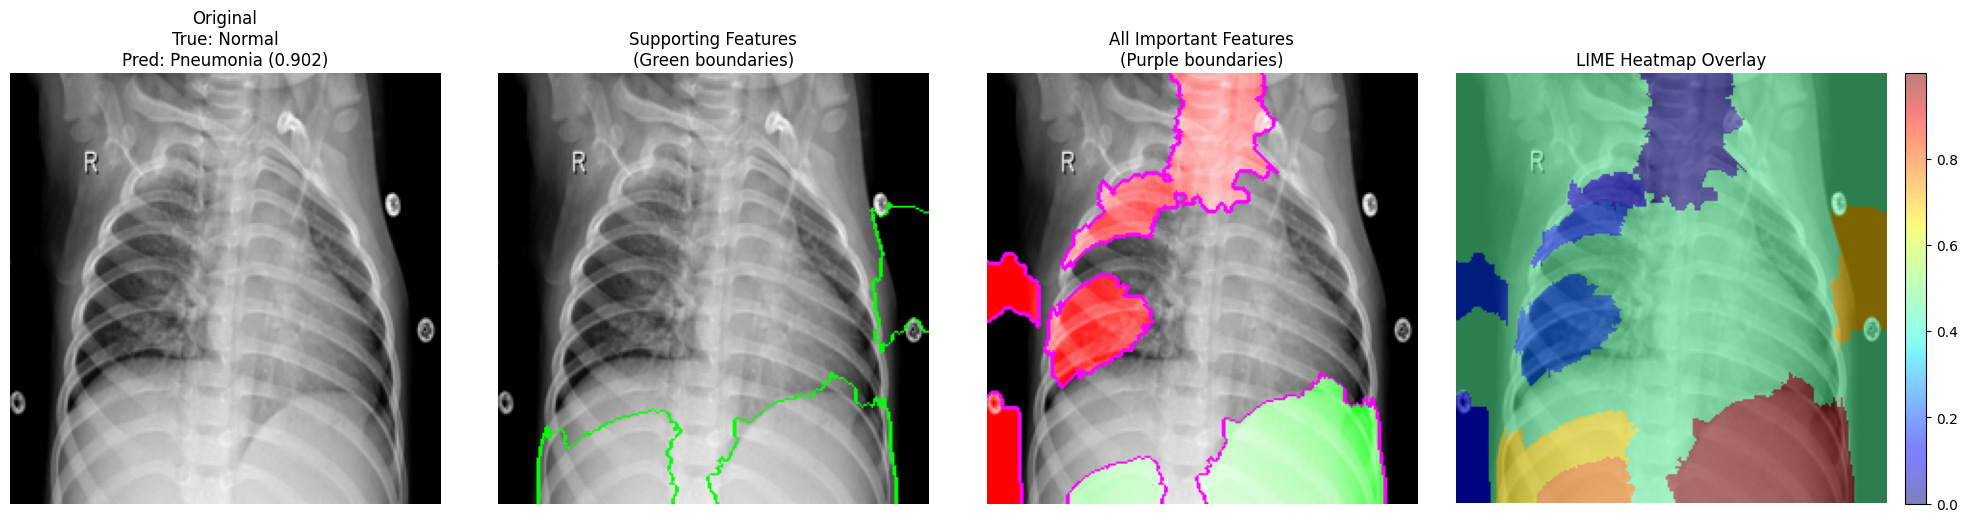


LIME TEST WITH HEATMAP COMPLETED SUCCESSFULLY! 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

class_names = ['Covid19', 'Normal', 'Pneumonia', 'Tuberculosis']


print("Setting up LIME test...")

def create_ensemble_predict_function(feature_model, rf_model, svm_model, meta_learner):
    def predict_fn(images):
        if images.max() > 1.0:
            images = images / 255.0
        features = feature_model.predict(images, verbose=0)
        rf_pred = rf_model.predict_proba(features)
        svm_pred = svm_model.predict_proba(features)
        stacked_features = np.hstack([rf_pred, svm_pred])
        final_pred = meta_learner.predict_proba(stacked_features)
        return final_pred
    return predict_fn

ensemble_predict_fn = create_ensemble_predict_function(feature_model, rf, svm, meta_learner)
print(" Ensemble prediction function created")

test_files = test_gen.filepaths
random_idx = random.randint(0, len(test_files) - 1)
test_image_path = test_files[random_idx]
true_class_idx = test_gen.classes[random_idx]

print(f"Selected test image: {os.path.basename(test_image_path)}")
print(f"True class: {class_names[true_class_idx]}")

image = Image.open(test_image_path).convert('RGB').resize((224, 224))
image_array = np.array(image)

print("Testing prediction function...")
test_pred = ensemble_predict_fn(np.expand_dims(image_array, axis=0))
pred_class = np.argmax(test_pred[0])
confidence = test_pred[0][pred_class]

print(f"Predicted class: {class_names[pred_class]} (confidence: {confidence:.3f})")
print(f"Prediction correct: {'YES' if pred_class == true_class_idx else 'NO'}")

print("Creating LIME explainer...")
explainer = lime_image.LimeImageExplainer()

print("Generating LIME explanation...")
explanation = explainer.explain_instance(
    image_array,
    ensemble_predict_fn,
    top_labels=len(class_names),
    hide_color=0,
    num_samples=100,
    num_features=10
)

print(" LIME explanation generated successfully!")


dict_weights = dict(explanation.local_exp[pred_class])  # {superpixel_id: weight}
segments = explanation.segments
heatmap = np.zeros(segments.shape)
for superpixel_id, weight in dict_weights.items():
    heatmap[segments == superpixel_id] = weight

#Normalize heatmap to 0-1 for visualization
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

#Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#Original image
axes[0].imshow(image_array)
axes[0].set_title(f'Original\nTrue: {class_names[true_class_idx]}\nPred: {class_names[pred_class]} ({confidence:.3f})')
axes[0].axis('off')

#Positive features only(green boundaries)
temp_pos, mask_pos = explanation.get_image_and_mask(
    pred_class, positive_only=True, num_features=5, hide_rest=False
)
axes[1].imshow(mark_boundaries(temp_pos / 255.0, mask_pos, color=(0, 1, 0)))
axes[1].set_title('Supporting Features\n(Green boundaries)')
axes[1].axis('off')

#All features(purple boundaries)
temp_all, mask_all = explanation.get_image_and_mask(
    pred_class, positive_only=False, num_features=8, hide_rest=False
)
axes[2].imshow(mark_boundaries(temp_all / 255.0, mask_all, color=(1, 0, 1)))
axes[2].set_title('All Important Features\n(Purple boundaries)')
axes[2].axis('off')

#Heatmap overlay
axes[3].imshow(image_array)
heatmap_im = axes[3].imshow(heatmap_norm, cmap='jet', alpha=0.5)  # alpha controls transparency
axes[3].set_title('LIME Heatmap Overlay')
axes[3].axis('off')
fig.colorbar(heatmap_im, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("LIME TEST WITH HEATMAP COMPLETED SUCCESSFULLY! ")
print("="*60)


Setting up LIME test with file upload...
 Ensemble prediction function created
Please upload an X-ray image...


Saving Covid-191.jpg to Covid-191.jpg
Uploaded file: Covid-191.jpg
Testing prediction function...
Predicted class: Pneumonia (confidence: 0.914)
Creating LIME explainer...
Generating LIME explanation...


  0%|          | 0/100 [00:00<?, ?it/s]

 LIME explanation generated successfully!


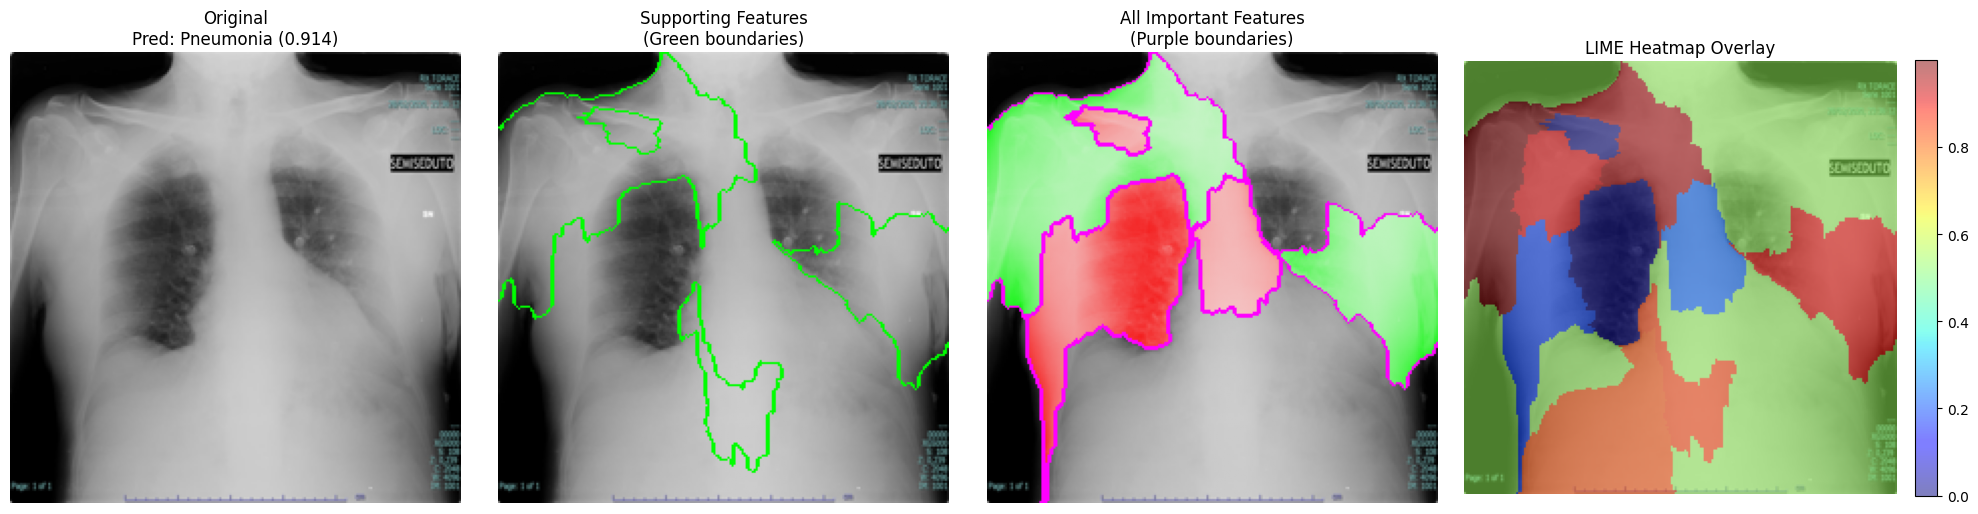


LIME TEST ON UPLOADED IMAGE COMPLETED SUCCESSFULLY! 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from google.colab import files


class_names = ['Covid19', 'Normal', 'Pneumonia', 'Tuberculosis']


print("Setting up LIME test with file upload...")

# ==== 1. Ensemble prediction function ====
def create_ensemble_predict_function(feature_model, rf_model, svm_model, meta_learner):
    def predict_fn(images):
        if images.max() > 1.0:
            images = images / 255.0
        features = feature_model.predict(images, verbose=0)
        rf_pred = rf_model.predict_proba(features)
        svm_pred = svm_model.predict_proba(features)
        stacked_features = np.hstack([rf_pred, svm_pred])
        final_pred = meta_learner.predict_proba(stacked_features)
        return final_pred
    return predict_fn

ensemble_predict_fn = create_ensemble_predict_function(feature_model, rf, svm, meta_learner)
print(" Ensemble prediction function created")

# ==== 2. Upload image ====
print("Please upload an X-ray image...")
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]


valid_extensions = ['.jpg', '.jpeg', '.png']
file_ext = os.path.splitext(uploaded_filename)[1].lower()

if file_ext not in valid_extensions:
    print(f" Upload failed: {uploaded_filename} is not a valid image file!")
else:
    image_path = uploaded_filename
    print(f"Uploaded file: {image_path}")

    # ==== 3. Load and preprocess uploaded image ====
    image = Image.open(image_path).convert('RGB').resize((224, 224))
    image_array = np.array(image)

    # ==== 4. Prediction ====
    print("Testing prediction function...")
    test_pred = ensemble_predict_fn(np.expand_dims(image_array, axis=0))
    pred_class = np.argmax(test_pred[0])
    confidence = test_pred[0][pred_class]

    print(f"Predicted class: {class_names[pred_class]} (confidence: {confidence:.3f})")

    # ==== 5. LIME explanation ====
    print("Creating LIME explainer...")
    explainer = lime_image.LimeImageExplainer()

    print("Generating LIME explanation...")
    explanation = explainer.explain_instance(
        image_array,
        ensemble_predict_fn,
        top_labels=len(class_names),
        hide_color=0,
        num_samples=100,
        num_features=10
    )
    print(" LIME explanation generated successfully!")

    # ==== 6. Plot results with heatmap overlay ====
    dict_weights = dict(explanation.local_exp[pred_class])
    segments = explanation.segments
    heatmap = np.zeros(segments.shape)
    for superpixel_id, weight in dict_weights.items():
        heatmap[segments == superpixel_id] = weight
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axes[0].imshow(image_array)
    axes[0].set_title(f'Original\nPred: {class_names[pred_class]} ({confidence:.3f})')
    axes[0].axis('off')

    # Positive features
    temp_pos, mask_pos = explanation.get_image_and_mask(
        pred_class, positive_only=True, num_features=5, hide_rest=False
    )
    axes[1].imshow(mark_boundaries(temp_pos / 255.0, mask_pos, color=(0, 1, 0)))
    axes[1].set_title('Supporting Features\n(Green boundaries)')
    axes[1].axis('off')

    # All important features
    temp_all, mask_all = explanation.get_image_and_mask(
        pred_class, positive_only=False, num_features=8, hide_rest=False
    )
    axes[2].imshow(mark_boundaries(temp_all / 255.0, mask_all, color=(1, 0, 1)))
    axes[2].set_title('All Important Features\n(Purple boundaries)')
    axes[2].axis('off')

    # Heatmap overlay
    axes[3].imshow(image_array)
    heatmap_im = axes[3].imshow(heatmap_norm, cmap='jet', alpha=0.5)
    axes[3].set_title('LIME Heatmap Overlay')
    axes[3].axis('off')
    fig.colorbar(heatmap_im, ax=axes[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("LIME TEST ON UPLOADED IMAGE COMPLETED SUCCESSFULLY! ")
    print("="*60)